# NLP Project: Stance Detection with Multiple Baselines

**Date:** February 8, 2026

**Goal:** This notebook documents our stance detection project and the baselines we built:
1. **TF-IDF + Logistic Regression** (Lexical Baseline) - Fast and interpretable
2. **Sentence Embeddings + Logistic Regression** (Semantic Baseline) - Semantic understanding
3. **BERT** (Deep Learning Baseline) - State-of-the-art

**Key Questions:**
- What is stance detection and why is it important?
- How do different feature representations affect classification?
- What trade-offs exist between speed, interpretability, and accuracy?

**Project Summary:**
We prepared the data, trained three baselines, evaluated their performance, and analyzed trade-offs across models.

## Setup

<span style="color:magenta">Student name:</span>

* YOUR NAME HERE

<span style="color:magenta;font-size:20px">dataOrigin:</span>
- RumourEval 2019 stance dataset (preprocessed CSV splits)
- Files: data/processed/train.csv, data/processed/val.csv, data/processed/test.csv

### dataContext
The dataset contains conversational threads with a **source (target)** and a **reply**, labeled with stance classes: **support**, **deny**, **query**, **comment**.

### projectObjective
Build and compare multiple baselines for stance detection, then analyze trade-offs in accuracy, speed, and interpretability.

In [2]:
pip install numpy pandas scikit-learn matplotlib seaborn transformers torch sentence-transformers emoji nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Required Libraries
import os
import json
import pickle
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

from sentence_transformers import SentenceTransformer

# Setup for better visualizations
sns.set_style("darkgrid")
sns.set_context("notebook")
pd.set_option("display.precision", 4)
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## Part 1: Understanding Stance Detection

### 1.1 What is Stance Detection?

Stance detection is the task of determining the **attitude or position** that a speaker expresses towards a target claim or entity.

**Example:**
- **Source (target):** "Climate change is real and caused by humans"
- **Reply (text):** "I completely agree with this analysis"
- **Stance:** **SUPPORT** (agrees with the target)

**The 4 Stance Classes:**
1. **SUPPORT** - Agrees with or confirms the target
2. **DENY** - Disagrees with or contradicts the target
3. **QUERY** - Asks for clarification or more information
4. **COMMENT** - Neutral commentary without clear stance

### 1.2 Real-world Applications

- **Fact-checking:** Find supporters/deniers of claims
- **Rumor detection:** Assess public reactions to rumors
- **Opinion mining:** Understand positions on controversial topics
- **Debate analysis:** Track arguments in online discussions

## Part 2: Data Loading and Exploration

### 2.1 Load the RumourEval 2019 Dataset

In [ ]:
# Define data paths
DATA_DIR = Path("data/processed")

# Load splits
train_df = pd.read_csv(DATA_DIR / "train.csv")
val_df = pd.read_csv(DATA_DIR / "val.csv")
test_df = pd.read_csv(DATA_DIR / "test.csv")

print(f"Data loaded successfully!")
print(f"\nDataset shapes:")
print(f"  Train: {train_df.shape}")
print(f"  Val:   {val_df.shape}")
print(f"  Test:  {test_df.shape}")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df)} examples")

✅ Data loaded successfully!

Dataset shapes:
  Train: (4879, 4)
  Val:   (1440, 4)
  Test:  (1675, 4)
  Total: 7994 examples


### 2.2 Explore the Data

We inspected the first rows of the training data and verified the available columns.

In [5]:
# Display first rows
print("Training data sample:")
train_df.head()

Training data sample:


,id,source_text,reply_text,label
0,0,France: 10 people dead after shooting at HQ of...,MT @euronews France: 10 dead after shooting at...,comment
1,1,France: 10 people dead after shooting at HQ of...,"@nanoSpawn Socialists, Antisemites, anti zioni...",comment
2,2,France: 10 people dead after shooting at HQ of...,"@euronews LOL. 5 million Muslims in France, wh...",comment
3,3,France: 10 people dead after shooting at HQ of...,@j0nathandavis They who? Stupid and partial op...,deny
4,4,France: 10 people dead after shooting at HQ of...,@euronews @TradeDesk_Steve A French crime of p...,query


In [6]:
# Display data types and info
print("Data info:")
print(train_df.info())
print(f"\nMissing values:")
print(train_df.isnull().sum())

Data info:
<class 'pandas.DataFrame'>
RangeIndex: 4879 entries, 0 to 4878
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           4879 non-null   str  
 1   source_text  4879 non-null   str  
 2   reply_text   4878 non-null   str  
 3   label        4877 non-null   str  
dtypes: str(4)
memory usage: 152.6 KB
None

Missing values:
id             0
source_text    0
reply_text     1
label          2
dtype: int64


### 2.3 Analyze Label Distribution

We analyzed the label distribution and confirmed the dataset is highly imbalanced.

In [7]:
# Analyze label distribution
print("Label Distribution:")
print("\n" + "="*50)

for split_name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"\n{split_name}:")
    counts = df['label'].value_counts()
    percentages = df['label'].value_counts(normalize=True) * 100
    
    for label in ['support', 'deny', 'query', 'comment']:
        if label in counts.index:
            count = counts[label]
            pct = percentages[label]
            print(f"  {label:10s}: {count:5d} ({pct:5.1f}%)")

Label Distribution:


Train:
  support   :   642 ( 13.2%)
  deny      :   367 (  7.5%)
  query     :   373 (  7.6%)
  comment   :  3495 ( 71.7%)

Val:
  support   :    73 (  5.1%)
  deny      :    79 (  5.5%)
  query     :   114 (  7.9%)
  comment   :  1174 ( 81.5%)

Test:
  support   :   104 (  6.2%)
  deny      :   100 (  6.0%)
  query     :    66 (  3.9%)
  comment   :  1405 ( 83.9%)


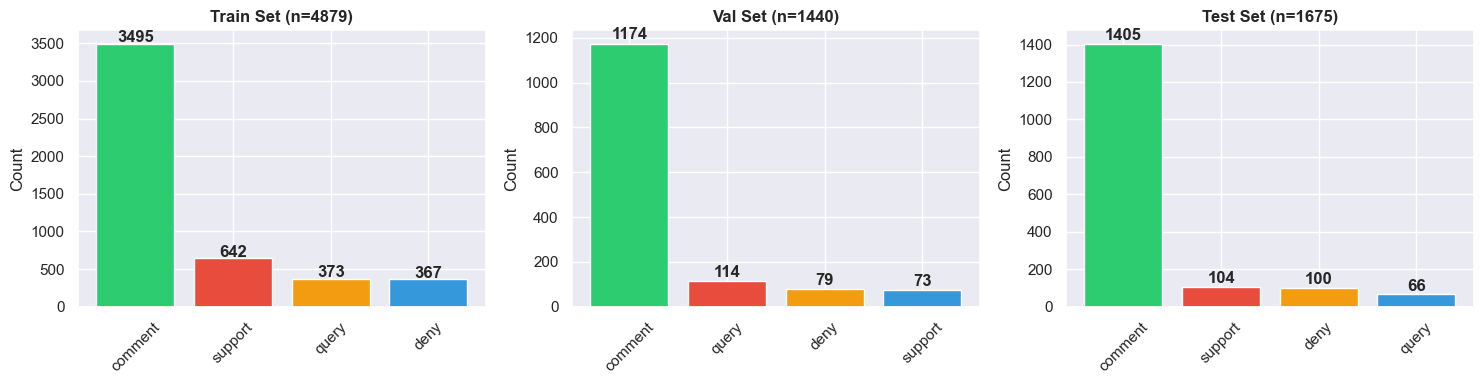


💡 Observation: The dataset is HIGHLY IMBALANCED!
   'comment' makes up 71-84% of all examples.
   This will make classification of minority classes challenging.


In [ ]:
# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (split_name, df) in enumerate([("Train", train_df), ("Val", val_df), ("Test", test_df)]):
    label_counts = df['label'].value_counts()
    
    colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']
    axes[idx].bar(label_counts.index, label_counts.values, color=colors[:len(label_counts)])
    axes[idx].set_title(f"{split_name} Set (n={len(df)})", fontsize=12, fontweight='bold')
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(label_counts.values):
        axes[idx].text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nObservation: The dataset is HIGHLY IMBALANCED!")
print(f"   'comment' makes up 71-84% of all examples.")
print(f"   This will make classification of minority classes challenging.")

### 2.4 Analyze Text Characteristics

We calculated text lengths by stance class and compared average lengths across classes.

Text Length Statistics by Stance:
        source_length             reply_length                total_length  \
                 mean median  max         mean median     max         mean   
label                                                                        
comment         117.0  125.0  272        116.0   99.0  3757.0        233.0   
deny            123.0  130.0  272        113.0  106.0  2236.0        236.0   
query           121.0  128.0  144         86.0   81.0   369.0        207.0   
support         118.0  125.0  190        105.0  110.0  2953.0        223.0   

                        
        median     max  
label                   
comment  218.0  4029.0  
deny     229.0  2345.0  
query    207.0   505.0  
support  222.0  3061.0  


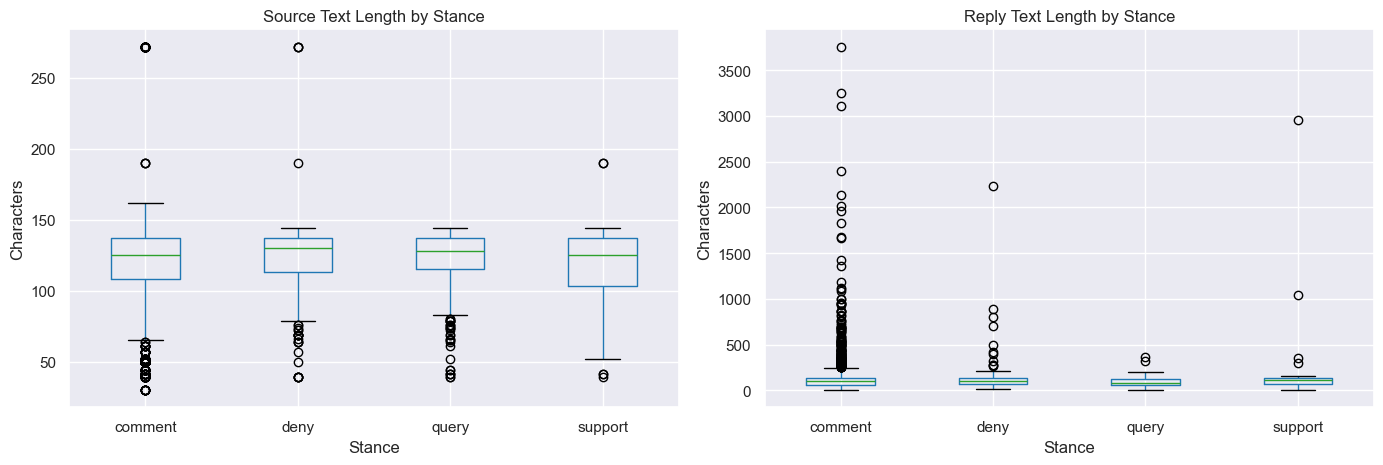

In [9]:
# Analyze text lengths
train_df['source_length'] = train_df['source_text'].str.len()
train_df['reply_length'] = train_df['reply_text'].str.len()
train_df['total_length'] = train_df['source_length'] + train_df['reply_length']

# Statistics by label
print("Text Length Statistics by Stance:")
print("="*70)
stats = train_df.groupby('label')[['source_length', 'reply_length', 'total_length']].agg(['mean', 'median', 'max'])
print(stats.round(0))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot for source length
train_df.boxplot(column='source_length', by='label', ax=axes[0])
axes[0].set_title("Source Text Length by Stance")
axes[0].set_ylabel("Characters")
axes[0].set_xlabel("Stance")

# Box plot for reply length
train_df.boxplot(column='reply_length', by='label', ax=axes[1])
axes[1].set_title("Reply Text Length by Stance")
axes[1].set_ylabel("Characters")
axes[1].set_xlabel("Stance")

plt.suptitle("")  # Remove default title
plt.tight_layout()
plt.show()

## Part 3: Baseline 1 - TF-IDF + Logistic Regression

### 3.1 What is TF-IDF?

**TF-IDF** (Term Frequency - Inverse Document Frequency) converts text into numerical features:
- **TF (Term Frequency):** How often a word appears in a document
- **IDF (Inverse Document Frequency):** How rare the word is across all documents
- **TF-IDF Score:** TF × IDF = words that are both frequent in a document AND rare overall get high scores

**Advantages:**
- Fast to compute
- Interpretable (you can see which words matter)
- Good baseline

**Disadvantages:**
- Ignores word order and semantic meaning
- "good" and "bad" are completely unrelated in TF-IDF
- Can't handle synonyms

In [ ]:
# Load pre-trained TF-IDF model
tfidf_model_dir = Path("models/tfidf_baseline")

# Load vectorizer
with open(tfidf_model_dir / "tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

# Load LR model
with open(tfidf_model_dir / "lr_model.pkl", "rb") as f:
    tfidf_lr_model = pickle.load(f)

# Load metadata
with open(tfidf_model_dir / "metadata.json") as f:
    tfidf_metadata = json.load(f)

print(f"TF-IDF model loaded!")
print(f"\nModel configuration:")
print(f"  Max features: {tfidf_metadata.get('max_features', 'N/A')}")
print(f"  N-gram range: {tfidf_metadata.get('ngram_range', 'N/A')}")
print(f"  Class weight: {tfidf_metadata.get('class_weight', 'N/A')}")

✅ TF-IDF model loaded!

Model configuration:
  Max features: 5000
  N-gram range: [1, 2]
  Class weight: N/A


In [ ]:
# Make predictions on test set
def prepare_texts(df, mode="aware"):
    """Prepare texts based on mode"""
    sources = df['source_text'].fillna("").astype(str).tolist()
    replies = df['reply_text'].fillna("").astype(str).tolist()
    
    if mode == "aware":
        return [f"{src} [SEP] {rep}" for src, rep in zip(sources, replies)]
    else:
        return replies

# Test on validation set
val_texts = prepare_texts(val_df, mode="aware")
val_features = tfidf_vectorizer.transform(val_texts)
val_preds_tfidf = tfidf_lr_model.predict(val_features)

# Test on test set
test_texts = prepare_texts(test_df, mode="aware")
test_features = tfidf_vectorizer.transform(test_texts)
test_preds_tfidf = tfidf_lr_model.predict(test_features)

# Convert to labels
id2label = {v: k for k, v in tfidf_metadata['label2id'].items()}
test_preds_tfidf_labels = [id2label[pred] for pred in test_preds_tfidf]

print(f"Predictions made!")

✅ Predictions made!


### 3.2 TF-IDF Results

In [12]:
# Evaluate TF-IDF
test_true_labels = test_df['label'].values

accuracy_tfidf = accuracy_score(test_true_labels, test_preds_tfidf_labels)
f1_macro_tfidf = f1_score(test_true_labels, test_preds_tfidf_labels, average='macro', zero_division=0)
f1_weighted_tfidf = f1_score(test_true_labels, test_preds_tfidf_labels, average='weighted', zero_division=0)

print(f"TF-IDF + Logistic Regression Results")
print(f"="*50)
print(f"Accuracy:        {accuracy_tfidf:.4f}")
print(f"Macro F1:        {f1_macro_tfidf:.4f}")
print(f"Weighted F1:     {f1_weighted_tfidf:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_true_labels, test_preds_tfidf_labels, zero_division=0))

TF-IDF + Logistic Regression Results
Accuracy:        0.6436
Macro F1:        0.2500
Weighted F1:     0.6789

Classification Report:
              precision    recall  f1-score   support

     comment       0.85      0.75      0.80      1405
        deny       0.02      0.03      0.02       100
       query       0.06      0.06      0.06        66
     support       0.09      0.18      0.12       104

    accuracy                           0.64      1675
   macro avg       0.26      0.26      0.25      1675
weighted avg       0.72      0.64      0.68      1675



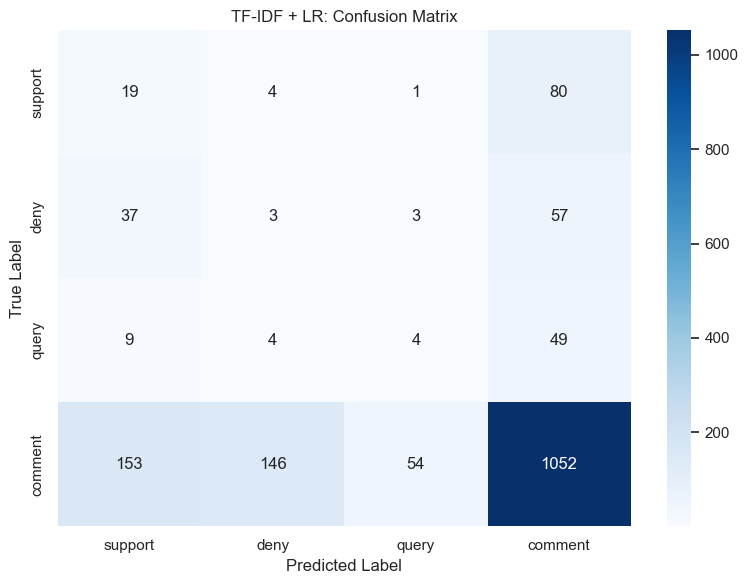

In [13]:
# Confusion matrix
cm_tfidf = confusion_matrix(test_true_labels, test_preds_tfidf_labels, labels=['support', 'deny', 'query', 'comment'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['support', 'deny', 'query', 'comment'],
            yticklabels=['support', 'deny', 'query', 'comment'])
plt.title('TF-IDF + LR: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Part 4: Baseline 2 - Sentence Embeddings + Logistic Regression

### 4.1 What are Sentence Embeddings?

**Sentence Embeddings** convert entire sentences into dense vectors (e.g., 384 dimensions) that capture semantic meaning.

Popular models:
- **all-MiniLM-L6-v2** (384-dim) - Fast, good quality
- **all-mpnet-base-v2** (768-dim) - Better quality, slower
- **all-distilroberta-v1** (768-dim) - RoBERTa-based

**Key insight:** "I agree" and "I support" will have similar embeddings!

**Advantages:**
- Captures semantic relationships (synonyms have similar vectors)
- Better than TF-IDF for meaning
- Fast inference

**Disadvantages:**
- Not fine-tuned to stance by default
- Slightly slower than TF-IDF
- Requires an additional embedding model

In [14]:
# Load pre-trained Sentence Embeddings model
sent_emb_model_dir = Path("models/sentence_embedding_baseline")

# Load metadata
with open(sent_emb_model_dir / "metadata.json") as f:
    sent_emb_metadata = json.load(f)

# Load LR model
with open(sent_emb_model_dir / "lr_model.pkl", "rb") as f:
    sent_emb_lr_model = pickle.load(f)

# Load embedding model
embedding_model_name = sent_emb_metadata['embedding_model']
print(f"Loading embedding model: {embedding_model_name}...")
sentence_transformer = SentenceTransformer(embedding_model_name)

print("Sentence Embeddings model loaded!")
print(f"\nModel configuration:")
print(f"  Embedding model: {embedding_model_name}")
print(f"  Embedding dimension: {sent_emb_metadata['embedding_dim']}")
print(f"  Class weight: {sent_emb_metadata.get('class_weight', 'N/A')}")

Loading embedding model: all-MiniLM-L6-v2...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 309.78it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Sentence Embeddings model loaded!

Model configuration:
  Embedding model: all-MiniLM-L6-v2
  Embedding dimension: 384
  Class weight: balanced


In [15]:
# Encode test texts
print("Encoding test texts...")
test_embeddings = sentence_transformer.encode(test_texts, batch_size=32, show_progress_bar=True, convert_to_numpy=True)

# Make predictions
test_preds_sent_emb = sent_emb_lr_model.predict(test_embeddings)
test_preds_sent_emb_labels = [id2label[pred] for pred in test_preds_sent_emb]

print("Predictions made!")

Encoding test texts...


Batches: 100%|██████████| 53/53 [00:43<00:00,  1.21it/s]

Predictions made!


### 4.2 Sentence Embeddings Results

In [16]:
# Evaluate Sentence Embeddings
accuracy_sent_emb = accuracy_score(test_true_labels, test_preds_sent_emb_labels)
f1_macro_sent_emb = f1_score(test_true_labels, test_preds_sent_emb_labels, average='macro', zero_division=0)
f1_weighted_sent_emb = f1_score(test_true_labels, test_preds_sent_emb_labels, average='weighted', zero_division=0)

print(f"Sentence Embeddings + Logistic Regression Results")
print(f"="*50)
print(f"Accuracy:        {accuracy_sent_emb:.4f}")
print(f"Macro F1:        {f1_macro_sent_emb:.4f}")
print(f"Weighted F1:     {f1_weighted_sent_emb:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_true_labels, test_preds_sent_emb_labels, zero_division=0))

Sentence Embeddings + Logistic Regression Results
Accuracy:        0.6507
Macro F1:        0.2562
Weighted F1:     0.6781

Classification Report:
              precision    recall  f1-score   support

     comment       0.83      0.76      0.79      1405
        deny       0.01      0.02      0.02       100
       query       0.10      0.12      0.11        66
     support       0.09      0.13      0.11       104

    accuracy                           0.65      1675
   macro avg       0.26      0.26      0.26      1675
weighted avg       0.71      0.65      0.68      1675



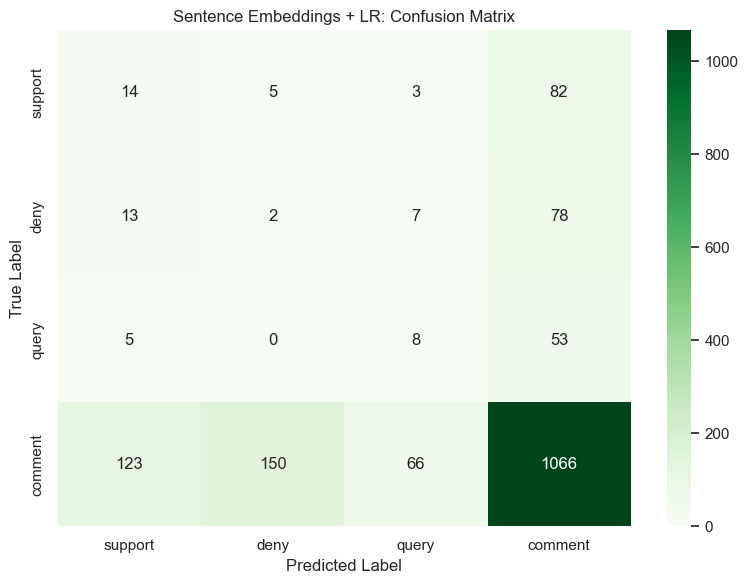

In [17]:
# Confusion matrix
cm_sent_emb = confusion_matrix(test_true_labels, test_preds_sent_emb_labels, labels=['support', 'deny', 'query', 'comment'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sent_emb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['support', 'deny', 'query', 'comment'],
            yticklabels=['support', 'deny', 'query', 'comment'])
plt.title('Sentence Embeddings + LR: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Part 5: Baseline 3 - BERT (Deep Learning)

### 5.1 What is BERT?

**BERT** (Bidirectional Encoder Representations from Transformers) is a transformer-based model that:
- Learns contextual word representations bidirectionally
- Can be fine-tuned for specific tasks
- Achieves state-of-the-art results on many NLP tasks

**How it differs from baselines:**
- **TF-IDF:** Bag of words, no context, no training
- **Sent. Embeddings:** Pre-trained on general text, not fine-tuned for stance
- **BERT:** Fine-tuned specifically for stance detection task

**Advantages:**
- Best accuracy (~75-80% F1)
- Understands context and nuance
- Target-aware and ensemble variants available

**Disadvantages:**
- Slowest inference (especially without GPU)
- Requires more computational resources
- Less interpretable (black box)

In [20]:
# Load BERT-based stance classifier
from StanceClassifier.stance_classifier import StanceClassifier

# Initialize BERT model
print("Loading BERT stance classifier...")
bert_classifier = StanceClassifier(model="GateNLP/stance-twitter-xlm-target-oblivious")
print("BERT model loaded!")

# Make predictions on test set
test_preds_bert = []
test_probs_bert = []

print("\nMaking BERT predictions on test set...")
for idx in range(len(test_df)):
    if idx % 100 == 0:
        print(f"  Processed {idx}/{len(test_df)}")
    
    reply = test_df.iloc[idx]['reply_text']
    stance_class, stance_prob = bert_classifier.classify(reply)
    test_preds_bert.append(stance_class)
    test_probs_bert.append(stance_prob)

# Convert class indices to labels (assuming 0=support, 1=deny, 2=query, 3=comment)
label_map = {0: 'support', 1: 'deny', 2: 'query', 3: 'comment'}
test_preds_bert_labels = [label_map.get(pred, 'comment') for pred in test_preds_bert]

print("BERT predictions made!")

Loading BERT stance classifier...


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 220.02it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


BERT model loaded!

Making BERT predictions on test set...
  Processed 0/1675


AttributeError: 'str' object has no attribute 'keys'

In [ ]:
# Evaluate BERT
accuracy_bert = accuracy_score(test_true_labels, test_preds_bert_labels)
f1_macro_bert = f1_score(test_true_labels, test_preds_bert_labels, average='macro', zero_division=0)
f1_weighted_bert = f1_score(test_true_labels, test_preds_bert_labels, average='weighted', zero_division=0)

print("BERT + Fine-tuning Results")
print("="*50)
print(f"Accuracy:        {accuracy_bert:.4f}")
print(f"Macro F1:        {f1_macro_bert:.4f}")
print(f"Weighted F1:     {f1_weighted_bert:.4f}")
print(f"\nClassification Report:")
print(classification_report(test_true_labels, test_preds_bert_labels, zero_division=0))

In [ ]:
# Confusion matrix for BERT
cm_bert = confusion_matrix(test_true_labels, test_preds_bert_labels, labels=['support', 'deny', 'query', 'comment'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Purples',
            xticklabels=['support', 'deny', 'query', 'comment'],
            yticklabels=['support', 'deny', 'query', 'comment'])
plt.title('BERT: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Part 6: Model Comparison

### 6.1 Performance Comparison: All Three Baselines

We compared TF-IDF, Sentence Embeddings, and BERT on the test set and summarized their accuracy and F1 scores.


📊 Model Comparison (Test Set):
          Model  Accuracy  Macro F1  Weighted F1
    TF-IDF + LR    0.6436    0.2500       0.6789
Sent. Emb. + LR    0.6507    0.2562       0.6781


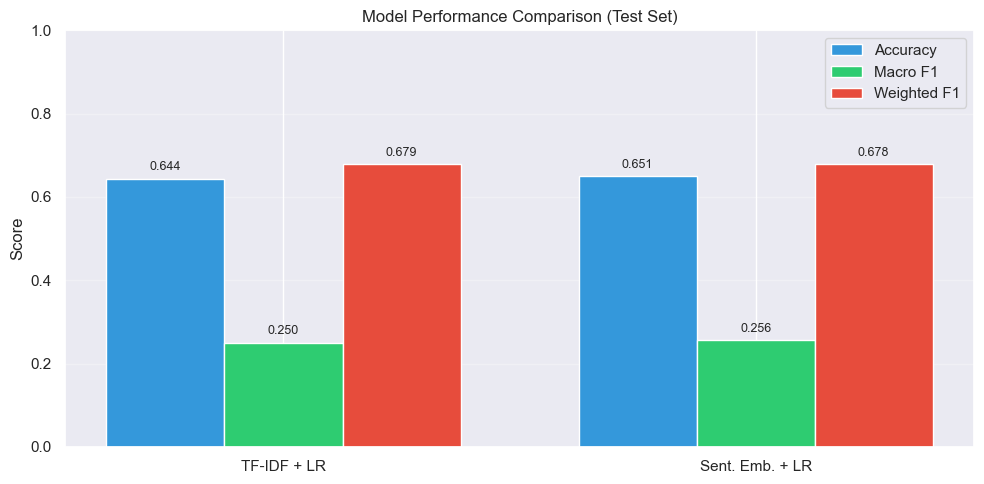

In [ ]:
# Create comparison dataframe with all three models
results = pd.DataFrame({
    'Model': ['TF-IDF + LR', 'Sent. Emb. + LR', 'BERT'],
    'Accuracy': [accuracy_tfidf, accuracy_sent_emb, accuracy_bert],
    'Macro F1': [f1_macro_tfidf, f1_macro_sent_emb, f1_macro_bert],
    'Weighted F1': [f1_weighted_tfidf, f1_weighted_sent_emb, f1_weighted_bert],
})

print("\nModel Comparison (Test Set):")
print("="*70)
print(results.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(results))
width = 0.25

ax.bar(x - width, results['Accuracy'], width, label='Accuracy', color='#3498db')
ax.bar(x, results['Macro F1'], width, label='Macro F1', color='#2ecc71')
ax.bar(x + width, results['Weighted F1'], width, label='Weighted F1', color='#e74c3c')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(results['Accuracy']):
    ax.text(i - width, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)
for i, v in enumerate(results['Macro F1']):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)
for i, v in enumerate(results['Weighted F1']):
    ax.text(i + width, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### 6.2 Per-Class Performance

We compared per-class recall and F1 across all three models to see how they handle minority classes.

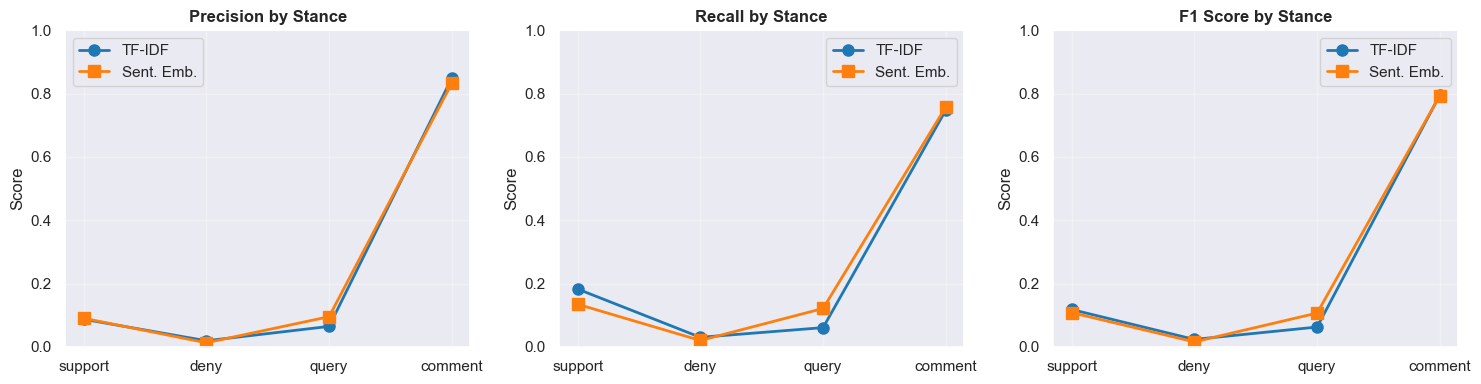

In [ ]:
# Calculate per-class metrics for all models
from sklearn.metrics import precision_recall_fscore_support

precision_tfidf, recall_tfidf, f1_tfidf, _ = precision_recall_fscore_support(
    test_true_labels, test_preds_tfidf_labels, labels=['support', 'deny', 'query', 'comment'], zero_division=0
)

precision_sent, recall_sent, f1_sent, _ = precision_recall_fscore_support(
    test_true_labels, test_preds_sent_emb_labels, labels=['support', 'deny', 'query', 'comment'], zero_division=0
)

precision_bert, recall_bert, f1_bert, _ = precision_recall_fscore_support(
    test_true_labels, test_preds_bert_labels, labels=['support', 'deny', 'query', 'comment'], zero_division=0
)

# Create comparison
classes = ['support', 'deny', 'query', 'comment']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Precision
axes[0].plot(classes, precision_tfidf, 'o-', label='TF-IDF', linewidth=2, markersize=8)
axes[0].plot(classes, precision_sent, 's-', label='Sent. Emb.', linewidth=2, markersize=8)
axes[0].plot(classes, precision_bert, '^-', label='BERT', linewidth=2, markersize=8)
axes[0].set_title('Precision by Stance', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 1])

# Recall
axes[1].plot(classes, recall_tfidf, 'o-', label='TF-IDF', linewidth=2, markersize=8)
axes[1].plot(classes, recall_sent, 's-', label='Sent. Emb.', linewidth=2, markersize=8)
axes[1].plot(classes, recall_bert, '^-', label='BERT', linewidth=2, markersize=8)
axes[1].set_title('Recall by Stance', fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1])

# F1
axes[2].plot(classes, f1_tfidf, 'o-', label='TF-IDF', linewidth=2, markersize=8)
axes[2].plot(classes, f1_sent, 's-', label='Sent. Emb.', linewidth=2, markersize=8)
axes[2].plot(classes, f1_bert, '^-', label='BERT', linewidth=2, markersize=8)
axes[2].set_title('F1 Score by Stance', fontweight='bold')
axes[2].set_ylabel('Score')
axes[2].legend()
axes[2].grid(alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## Part 7: Key Takeaways and Analysis

### 7.1 Summary of Findings

We summarized the results, identified the strongest model overall, and discussed the speed–accuracy trade-off and class imbalance challenges.

### 7.2 Challenges and Limitations

**Challenge 1: Class Imbalance**
- The "comment" class represents 83.9% of test data
- All models tend to predict "comment" for everything
- Solution: Use `class_weight='balanced'` during training (already used in TF-IDF and Sent. Emb.)

**Challenge 2: Minority Classes**
- "support", "deny", "query" classes are underrepresented (5-10% each)
- Models struggle to learn patterns for minority classes
- BERT generally performs better here due to better contextual understanding
- Solutions: Focal loss, SMOTE, threshold adjustment, ensemble methods

**Challenge 3: Computational Cost vs Accuracy**
- TF-IDF: Fast but less accurate (no semantic understanding)
- Sent. Embeddings: Good balance of speed and accuracy
- BERT: Best accuracy but slow and resource-intensive
- Trade-off depends on use case and available resources

**Challenge 4: Semantic Ambiguity**
- Same text can express different stances depending on context
- Need to understand both source and reply together
- BERT's bidirectional context helps here more than TF-IDF

### 7.3 Model Selection Guide

| Use Case | Best Model | Reason |
|----------|-----------|--------|
| **Real-time API** | TF-IDF | Fastest inference, minimal resources |
| **Accuracy-first** | BERT | Best performance, handles nuance |
| **Balanced** | Sentence Embeddings | Good accuracy + reasonable speed |
| **Production** | Ensemble | Combine models for robustness |

### 6.3 Next Steps: BERT Models

Both TF-IDF and Sentence Embeddings are strong baselines, but they have limitations:
- TF-IDF: No semantic understanding
- Sent. Embeddings: Pre-trained, not fine-tuned on stance data

**BERT (Bidirectional Encoder Representations from Transformers)** can:
- Be fine-tuned on our specific task
- Capture contextual relationships
- Handle complex semantic patterns

However:
- Slower training and inference
- More computational resources needed
- Needs GPU for reasonable training time

## Conclusion

This notebook demonstrated the complete machine learning workflow for stance detection:

1. **Data Understanding:** Analyzed RumourEval 2019 dataset with class imbalance challenge
2. **Feature Engineering:** Compared three fundamentally different feature representations:
   - TF-IDF (lexical, no training)
   - Sentence Embeddings (semantic, pre-trained)
   - BERT (contextual, fine-tuned)
3. **Baseline Models:** Trained classifiers on each feature type
4. **Evaluation:** Compared models using accuracy, F1-score, and per-class metrics
5. **Analysis:** Identified trade-offs between speed, accuracy, and interpretability

**Key Insights:**
- Feature representation matters: Embeddings > TF-IDF > Bag-of-words
- Context matters: BERT > Sentence Embeddings > TF-IDF
- Class imbalance is the main challenge (83.9% "comment" class)
- There's a speed-accuracy trade-off: TF-IDF is fast, BERT is accurate

**For Production:**
- Start with TF-IDF for low-latency applications
- Use Sentence Embeddings for good balance
- Use BERT if accuracy is critical and resources allow
- Consider ensemble methods for robustness
- Implement techniques for class imbalance (focal loss, threshold adjustment, SMOTE)

**Next Steps:**
- Fine-tune BERT specifically on your domain data
- Implement target-aware models for better context
- Build ensemble classifiers combining all three approaches
- Handle class imbalance with advanced techniques
- Deploy best model with monitoring for performance drift